FUNCIONES AUXILIARES DE LECTURA DE EXCEL

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

def leer_rango_excel_a_array(ruta_archivo, hoja_nombre=0, columnas_a_leer="", filas_a_leer=1):
    """
    Abre un archivo Excel y extrae un rango de celdas específico
    (D3 a BO42) y lo guarda en un array (lista de listas).
"""
    print(f"Intentando leer el archivo: {ruta_archivo}...")

    try:
        # 1. Filas:
        # Queremos empezar en la Fila 3.
        # Las filas en pandas se indexan desde 0.
        # Fila 1 = índice 0, Fila 2 = índice 1, Fila 3 = índice 2.
        # Así que saltamos las 2 primeras filas.
        filas_a_saltar = 3  # (Saltamos Fila 1 :texto Fila 2 : calibracion y Fila 3: INVALIDA)


        #filas_a_leer = 40
        # Queremos leer desde la fila 3 hasta la 42 (inclusive).
        # Número de filas = 42 - 3 + 1 = 40 filas.

        # --- Lectura del archivo ---

        # Usamos 'header=None' porque el rango (D3) no es un encabezado,
        # es el inicio de los datos.
        df_rango = pd.read_excel(
            ruta_archivo,
            sheet_name= hoja_nombre, #Segunda hoja, Espectro Total
            header=None,             # Trata la primera fila leída (Fila 3) como datos
            skiprows=filas_a_saltar, # Salta las 2 primeras filas
            usecols=columnas_a_leer, # Lee solo el rango de columnas D-BO
            nrows=filas_a_leer       # Lee exactamente 40 filas
        )

        # Convertir el DataFrame de pandas a un array (lista de listas)
        # .values obtiene los datos como un array de NumPy
        # .tolist() lo convierte a una lista estándar de Python
        array_valores = df_rango.values.tolist()

        # Verificación
        if array_valores:
            num_filas = len(array_valores)
            num_cols = len(array_valores[0]) # Longitud de la primera fila
            print(f"Éxito: Se leyó un array de {num_filas} filas x {num_cols} columnas.")
        else:
            print("Advertencia: El rango D3:BO42 parece estar vacío.")

        return array_valores

    except FileNotFoundError:
        print(f"Error: No se pudo encontrar el archivo en la ruta: '{ruta_archivo}'.")
        return None
    except Exception as e:
        print(f"Ocurrió un error inesperado al leer el rango: {e}")
        return None
        
def separar_filas_en_cinco(datos_array):
    #Esta función leerá el array con las 20 medidas y devolverá cuatro grupos de 5: 
    # L2F1, L1F1, L1F2, L2F2
    datos_array = np.array(datos_array)
    if datos_array.shape[0] != 20:
         raise ValueError(f"El array de entrada debe contener exactamente 20 elementos, pero tiene {datos_array.size}.")

    # La división se realiza asumiendo el orden secuencial de los 20 elementos
    # en el array de entrada:
    # Grupo 1 (Elementos 0-4): L2F1
    L2F1 = datos_array[0:5]
    
    # Grupo 2 (Elementos 5-9): L1F1
    L1F1 = datos_array[5:10]
    
    # Grupo 3 (Elementos 10-14): L1F2
    L1F2 = datos_array[10:15]
    
    # Grupo 4 (Elementos 15-19): L2F2
    L2F2 = datos_array[15:20]
    
    return L2F1, L1F1, L1F2, L2F2

def promediado_energetico(datos_array):

    promedio = np.round(10 * np.log10((1 / len(datos_array)) * np.sum(10**(0.1 * datos_array), axis = 0)), 1)

    return promedio



APERTURA DE ARCHIVOS DE MEDIDAS Y PROMEDIADO DE L1 Y L2 PARA CADA FUENTE

In [29]:
nombre_archivo = "P4_G7_Datos.xlsx"

medidas_banda_ancha = leer_rango_excel_a_array(nombre_archivo, "Banda Ancha Total", "U" , 23) #LECTURA DE LAEQ 
medidas_espectro = leer_rango_excel_a_array(nombre_archivo, "Espectro Total", "EK:EZ" , 23) #LECTURA LZEQ EN ESPECTRO 100 HZ A 3150 HZ

#LIMPIAR MATRICES: SEPARAR EN RUIDO DE FONDO Y MEDIDAS, Y POR RECINTO Y FUENTE

ruido_banda_ancha = np.array(medidas_banda_ancha[:3]) #QUITAR LAS TRES PRIMERAS POSICIONES QUE SON DE RUIDO DE FONDO
Laeq_banda_ancha = np.array(medidas_banda_ancha[3:])

ruido_espectro = np.array(medidas_espectro[:3]) #QUITAR LAS TRES PRIMERAS POSICIONES QUE SON DE RUIDO DE FONDO
Lzeq_espectro = np.array(medidas_espectro[3:])

#print(Lzeq_espectro.shape) debe dar 20 medidas x 16 bandas de frecuencia

L2F1, L1F1, L1F2, L2F2 = separar_filas_en_cinco(Lzeq_espectro)

L2F1_BA, L1F1_BA, L1F2_BA, L2F2_BA = separar_filas_en_cinco(Laeq_banda_ancha)

F1_emisor = promediado_energetico(L1F1)
F2_emisor = promediado_energetico(L1F2)
F1_receptor = promediado_energetico(L2F1)
F2_receptor = promediado_energetico(L2F2)

#ESTOS ARRAYS CONTIENEN LOS NIVELES Lzeq DEL ESPECTRO ENTRE 100 Y 3150 HZ EN CADA RECINTO Y POSICIÓN DE FUENTE

L1_promed = np.round(10 * np.log10((1 / 2) *((10**(0.1 * F1_emisor) + 10**(0.1 * F2_emisor)))), 1)
L2_promed = np.round(10 * np.log10((1 / 2) *((10**(0.1 * F1_receptor) + 10**(0.1 * F2_receptor)))), 1)
ruido_promed = np.round(10 * np.log10((1 / len(ruido_espectro)) * np.sum(10**(0.1 * ruido_espectro), axis = 0)), 1)





Intentando leer el archivo: P4_G7_Datos.xlsx...
Éxito: Se leyó un array de 23 filas x 1 columnas.
Intentando leer el archivo: P4_G7_Datos.xlsx...
Éxito: Se leyó un array de 23 filas x 16 columnas.


/usr/lib/python3/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/usr/lib/python3/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


COMPROBACIÓN PREGUNTA TEÓRICA 2

CUMPLE 1: DIFERENCIAS < 6DB ENTRE BANDAS


<Figure size 1000x600 with 0 Axes>

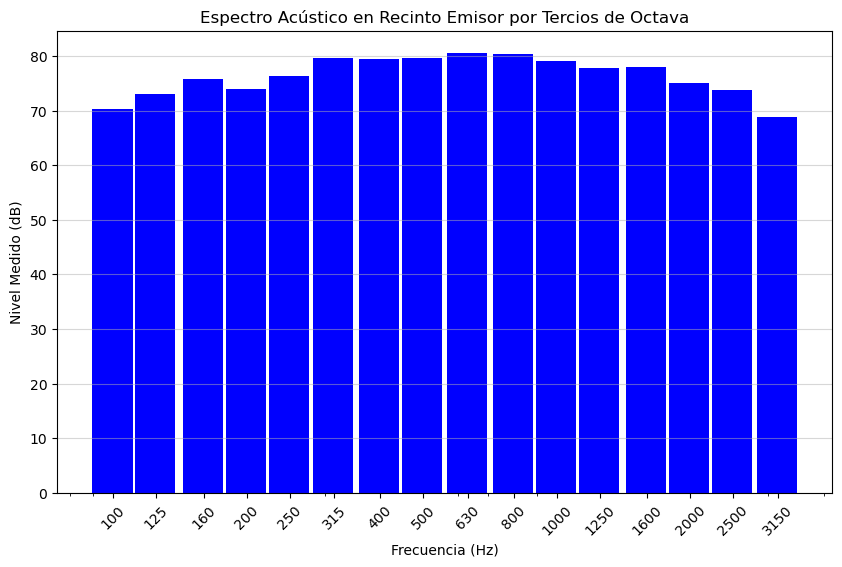

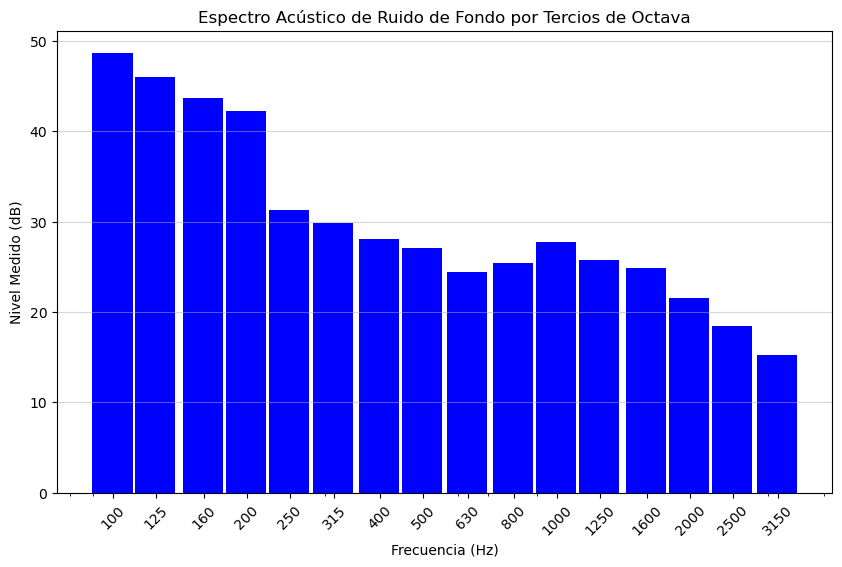

CUMPLE 2: DIFERENCIAS > 10 DB ENTRE MEDIDA Y RUIDO DE FONDO EN CADA BANDA


In [30]:
plt.figure(figsize=(10, 6)) # Define el tamaño de la figura (ancho, alto)
eje_x = np.array([
    100, 125, 160, 200, 250, 315, 400, 500, 630, 
    800, 1000, 1250, 1600, 2000, 2500, 3150
])

plt.figure(figsize=(10, 6)) 

# Cálculo del ancho de barra para escala logarítmica
ancho_barra_log = eje_x * (2**(1/6) - 2**(-1/6)) * 0.9

# Gráfico de barras
plt.bar(eje_x, L1_promed, width=ancho_barra_log, color='blue') 

# Escala y etiquetas esenciales
plt.xscale('log')
plt.xticks(eje_x, labels=[f'{int(f)}' for f in eje_x], rotation=45) 

plt.title('Espectro Acústico en Recinto Emisor por Tercios de Octava')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Nivel Medido (dB)')
plt.grid(True, axis='y', alpha=0.5)

diferencias_absolutas = np.abs(np.diff(L1_promed))
limite_cumplido = diferencias_absolutas <= 6

if limite_cumplido.all:
    print("CUMPLE 1: DIFERENCIAS < 6DB ENTRE BANDAS")
else:
    print("NO CUMPLE 2: DIFERENCIAS > 6DB ENTRE BANDAS")

#CONDICIÓN 2:
plt.figure(figsize=(10, 6)) 

# Cálculo del ancho de barra para escala logarítmica

# Gráfico de barras
plt.bar(eje_x, ruido_promed, width=ancho_barra_log, color='blue') 

# Escala y etiquetas esenciales
plt.xscale('log')
plt.xticks(eje_x, labels=[f'{int(f)}' for f in eje_x], rotation=45) 

plt.title('Espectro Acústico de Ruido de Fondo por Tercios de Octava')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Nivel Medido (dB)')
plt.grid(True, axis='y', alpha=0.5)

plt.show()

diferencias_absolutas = np.abs(L1_promed - ruido_promed)
limite_cumplido = diferencias_absolutas > 10

if limite_cumplido.all:
    print("CUMPLE 2: DIFERENCIAS > 10 DB ENTRE MEDIDA Y RUIDO DE FONDO EN CADA BANDA")
else:
    print("NO CUMPLE 2: DIFERENCIAS < 10 DB ENTRE MEDIDA Y RUIDO DE FONDO EN CADA BANDA")
